In [1]:
# --> Import standard functions from numpy.
import numpy as np
from numpy.random import normal

# --> Import matplotlib and set related parameters.
import matplotlib.pyplot as plt
fig_width = 12

# --> Import SciPy utility functions for linear dynamical systems.
from scipy.signal import lti
from scipy.signal import dlti, dlsim

# --> Import standard linear algebra functions from SciPy.
from scipy.linalg import norm

# --> Import various DMD algorithms available in PyDMD.
from pydmd import DMD, OptDMD

# Tutorial 8 : Comparison of various DMD algorithms

In this tutorial, we perform a thorough comparison of various DMD algorithms available in PyDMD, namely:
- the original DMD algorithm proposed by [Schmid (*J. Fluid Mech.*, 2010)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/dynamic-mode-decomposition-of-numerical-and-experimental-data/AA4C763B525515AD4521A6CC5E10DBD4), see `DMD`
- the optimal closed-form solution given by [Héas & Herzet (*arXiv*, 2016)](https://arxiv.org/abs/1610.02962), see `OptDMD`.

For that purpose, different test cases are considered in order to assess the accuracy, the computational efficiency and the generalization capabilities of each method. The system we'll consider throughout this notebook is that of a chain of slightly damped 1D harmonic oscillators with nearest-neighbours coupling. Defining the state-vector as

$$
    \mathbf{x} = \begin{bmatrix} \mathbf{q} & \mathbf{p} \end{bmatrix}^T,
$$

where $\mathbf{q}$ is the position and $\mathbf{p}$ is the momentum, our linear system can be written as

$$
    \displaystyle \frac{\mathrm{d}}{\mathrm{d}t} \begin{bmatrix} \mathbf{q} \\ \mathbf{p} \end{bmatrix} = \begin{bmatrix} \mathbf{0} & \mathbf{I} \\ -\mathbf{K} & -\mathbf{G} \end{bmatrix} \begin{bmatrix} \mathbf{q} \\ \mathbf{p} \end{bmatrix},
$$

with $\mathbf{K}$ and $\mathbf{G}$ being the stiffness and friction matrices, respectively. It must be emphasized that, because we consider $N=50$ identifical oscillators, this system does not exhibit low-rank dynamics. It will nonetheless enable us to further highlight the benefits of using the optimal solution proposed by [Héas & Herzet (arXiv, 2016)](https://arxiv.org/abs/1610.02962) as opposed to the other algorithms previously available in PyDMD.

Three different test cases will be considered :
- fitting a DMD model using a single long time-series,
- fitting a DMD model using a short burst,
- fitting a DMD model using an ensemble of short bursts.

For each case, the reconstruction error on the training dataset used to fit the model will be reported along with the error on an ensemble of testing datasets as to assess the generalization capabilities of these various DMD models. The following two cells build the discrete linear time invariant (LTI) state space model for our system. It is this particular system, hereafter denoted `dsys`, that will be used throughout this notebook to generate both the training and testing datasets. For more details about SciPy implementation of LTI systems, interested readers are refered to the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html#discrete-time-linear-systems) module.

In [2]:
def harmonic_oscillators(N=10, omega=0.1, alpha=0.2, gamma=0.05, dt=1.0):
    
    """
    This function builds the discrete-time model of a chain of N coupled
    weakly damped harmonic oscillators. All oscillators are identical to
    one another and have a nearest-neighbour coupling.
    
    Parameters
    ----------
    N : integer
        The number of oscillators forming the chain (default 10).
        
    omega : float
            The natural frequency of the base oscillator (default 0.1).
            
    alpha : float
            The nearest-neighbour coupling strength (default 0.2).
            
    gamma : float
            The damping parameter (default 0.05).
            
    dt    : float
            The sampling period for the continuous-to-discrete time conversion (default 1.0).
    
    Returns
    -------
    dsys :  scipy.signal.dlti
            The corresponding discrete-time state-space model.
    
    """
    
    # --> Miscellaneous imports.
    from scipy.sparse import diags, identity, bmat, block_diag
    
    # --> Build the stiffness matrix.
    K_ii = np.ones((N,)) * (omega**2/2.0 + alpha) # Self-coupling.
    K_ij = np.ones((N-1,)) * (-alpha/2.0) # Nearest-neighbor coupling.
    K = diags([K_ij, K_ii, K_ij], offsets=[-1, 0, 1]) # Assembles the stiffness matrix.
    
    # --> Build the friction matrix.
    G = gamma * identity(N)
    
    # --> Build the dynamic matrix.
    A = bmat([[None, identity(N)], [-K, -G]])
    
    # --> Build the control matrix.
    B = bmat([[0*identity(N)], [identity(N)]])
    
    # --> Build the observation matrix.
    C = identity(2*N)
    
    # --> Build the feedthrough matrix.
    D = bmat([[0*identity(N)], [0*identity(N)]])
    
    # --> SciPy continuous-time LTI object.
    sys = lti(A.toarray(), B.toarray(), C.toarray(), D.toarray())
    
    # --> Return the discrete-time equivalent.
    return sys.to_discrete(dt)

In [3]:
# --> Get the discrete-time LTI model.
N = 50 # Number of oscillators (each has 2 degrees of freedom so the total size of the system is 2N).
dsys = harmonic_oscillators(N=N) # Build the model.

## Case 1 : Using a single long time-series to fit a DMD model

In [4]:
# --> Training initial condition.
x0_train = normal( loc=0.0, scale=1.0, size=(dsys.A.shape[1]) )

# --> Run simulation to generate dataset.
t, _, x_train = dlsim(dsys, np.zeros((2000, dsys.inputs)), x0=x0_train)

In [5]:
def plot_training_dataset(t, x_train):
    
    """
    This is a simple utility function to plot the time-series forming our training dataset.
    
    Parameters
    ----------
    
    t : array-like, shape (n_samples,)
        The time instants.
    x_train : array-like, shape (n_samples, n_dof)
        The time-series of our system.

    """

    # --> Setup the figure.
    fig, axes = plt.subplots( 1, 2, sharex=True, figsize=(fig_width, fig_width/6) )

    # --> Plot the oscillators' positions.
    axes[0].plot( t, x_train[:, :dsys.inputs], alpha=0.5)

    # --> Add decorators.
    axes[0].set_ylabel(r"$q_i[k]$")
    
    # --> Plot the oscillators'velocities.
    axes[1].plot( t, x_train[:, dsys.inputs:], alpha=0.5 )

    # --> Add decorators.
    axes[1].set( xlim=(t.min(), t.max()), xlabel=r"k", ylabel=r"p_i[k]$" )
    
    return

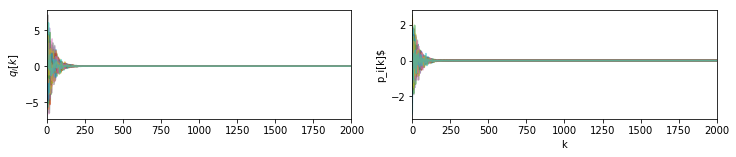

In [6]:
plot_training_dataset(t, x_train)

Let us now fit our models, namely vanilla DMD (Schmid, *J. Fluid Mech.*, 2010) and the closed-form solution DMD (Héas & Herzet, *arXiv*, 2016).

In [7]:
def rank_sensitvity(dsys, x_train, n_test=100):
    
    """
    This function using the generated training dataset to fit DMD and OptDMD models of increasing rank.
    It also computes the test error on an ensemble of testing dataset to get a better estimation of the
    generalization capabilities of the fitted models.
    
    Parameters
    ----------
    
    dsys : scipy.signal.dlti
        The discrete LTI system considered.
        
    x_train : array-like, shape (n_features, n_samples)
        The training dataset.
        NOTE : It is transposed compared to the output of dsys.
        
    n_test : int
        The number of testing datasets to be generated.
        
    Returns
    -------
    
    dmd_train_error : array-like, shape (n_ranks,)
        The reconstruction error of the DMD model on the training data.
        
    dmd_test_error : array-like, shape (n_ranks, n_test)
        The reconstruction error of the DMD model on the various testing datasets.
        
    optdmd_train_error : array-like, shape (n_ranks,)
        The reconstruction error of the OptDMD model on the training data.
        
    optdmd_test_error : array-like, shape (n_ranks, n_test)
        The reconstruction error of the OptDMD model on the various testing datasets.
        
    
    """
    
    # -->
    dmd_train_error, optdmd_train_error = list(), list()
    dmd_test_error, optdmd_test_error = list(), list()

            
    # --> Split the training data into input/output snapshots.
    y_train, X_train = x_train[:, 1:], x_train[:, :-1]
    
    for rank in range(1, dsys.A.shape[0]+1):
        
        # --> Fit the DMD model (Schmid's algorithm)
        dmd = DMD(svd_rank=rank).fit(x_train)
        
        # --> Fit the DMD model (optimal closed-form solution)
        optdmd = OptDMD(svd_rank=rank, factorization="svd").fit(x_train)

        # --> One-step ahead prediction using both DMD models.
        y_predict_dmd = dmd.predict(X_train)
        y_predict_opt = optdmd.predict(X_train)

        # --> Compute the one-step ahead prediction error.
        dmd_train_error.append( norm(y_predict_dmd-y_train)/norm(y_train) )
        optdmd_train_error.append( norm(y_predict_opt-y_train)/norm(y_train) ) 
        
        # --> Evaluate the error on test data.
        dmd_error, optdmd_error = list(), list()
        for _ in range(n_test):
            # --> Test initial condition.
            x0_test = normal( loc=0.0, scale=1.0, size=(dsys.A.shape[1]) )

            # --> Run simulation to generate dataset.
            t, _, x_test = dlsim(dsys, np.zeros((250, dsys.inputs)), x0=x0_test)
            
            # --> Split the training data into input/output snapshots.
            y_test, X_test = x_test.T[:, 1:], x_test.T[:, :-1]

            # --> One-step ahead prediction using both DMD models.
            y_predict_dmd = dmd.predict(X_test)
            y_predict_opt = optdmd.predict(X_test)

            # --> Compute the one-step ahead prediction error.
            dmd_error.append( norm(y_predict_dmd-y_test)/norm(y_test) )
            optdmd_error.append( norm(y_predict_opt-y_test)/norm(y_test) ) 

        # --> Store the error for rank i DMD.
        dmd_test_error.append( np.asarray(dmd_error) )
        optdmd_test_error.append( np.asarray(optdmd_error) )

    # --> Complete rank-sensitivity.
    dmd_test_error = np.asarray(dmd_test_error)
    optdmd_test_error = np.asarray(optdmd_test_error)
    
    dmd_train_error = np.asarray(dmd_train_error)
    optdmd_train_error = np.asarray(optdmd_train_error)
    
    return dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error

In [8]:
def plot_rank_sensitivity(dmd_train_error, dmd_test_error, optdmd_train_error, optdmd_test_error):
    
    """
    Simple utility function to plot the results from the rank sensitivity analysis.
    
    Parameters
    ----------
    
    dmd_train_error : array-like, shape (n_ranks,)
        The reconstruction error of the DMD model on the training data.
        
    dmd_test_error : array-like, shape (n_ranks, n_test)
        The reconstruction error of the DMD model on the various testing datasets.
        
    optdmd_train_error : array-like, shape (n_ranks,)
        The reconstruction error of the OptDMD model on the training data.
        
    optdmd_test_error : array-like, shape (n_ranks, n_test)
        The reconstruction error of the OptDMD model on the various testing datasets.

    
    """
    
    # --> Generate figure.
    fig, axes = plt.subplots( 1, 2, figsize=(fig_width, fig_width/4), sharex=True, sharey=True )
    
    # --> Misc.
    rank = np.arange(1, dmd_test_error.shape[0]+1)
    
    #####
    #####    TRAINING ERROR
    #####
    
    # --> Plot the vanilla DMD error.    
    axes[0].plot( rank, dmd_train_error )
    # --> Plot the OptDMD error.
    axes[0].plot( rank, optdmd_train_error, ls="--" )
    # --> Add decorators.
    axes[0].set(
        xlabel=r"Rank of the DMD model", ylabel=r"Normalized error", title=r"Training dataset"
    )
    axes[0].grid(True)
    
    #####
    #####     TESTING ERROR
    #####
    
    # --> Plot the vanilla DMD error.
    axes[1].plot( rank, np.mean(dmd_test_error, axis=1), label=r"Regular DMD" )
    axes[1].fill_between(
        rank,
        np.mean(dmd_test_error, axis=1) + np.std(dmd_test_error, axis=1),
        np.mean(dmd_test_error, axis=1) - np.std(dmd_test_error, axis=1),
        alpha=0.25,
    )
    # --> Plot the OptDMD error.
    axes[1].plot( rank, np.mean(optdmd_test_error, axis=1), ls="--", label=r"Optimal DMD" )
    axes[1].fill_between(
        rank,
        np.mean(optdmd_test_error, axis=1) + np.std(optdmd_test_error, axis=1),
        np.mean(optdmd_test_error, axis=1) - np.std(optdmd_test_error, axis=1),
        alpha=0.25,
    )
    # --> Add decorators.
    axes[1].set(
        xlim = (0, rank.max()), xlabel=r"Rank of the DMD model",
        ylim=(0, 1),
        title=r"Testing dataset"
    )
    axes[1].grid(True)
    axes[1].legend(loc=0)
    
    return

In [9]:
# --> Run the rank-sensitivity analysis.
output = rank_sensitvity(dsys, x_train.T)

# --> Keep for later use.
long_time_series_optdmd_train, long_time_series_optdmd_test = output[2], output[3]

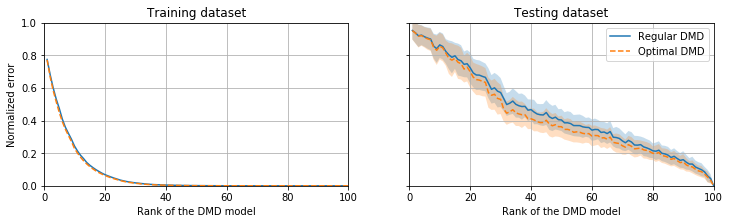

In [10]:
# --> Plot the results.
plot_rank_sensitivity(*output)

## Case 2 : Using a short burst to fit a DMD model

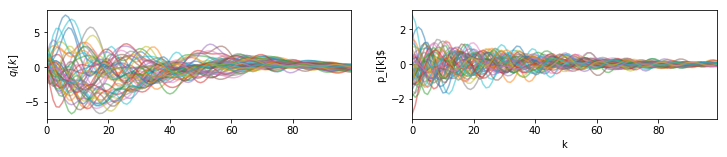

In [11]:
# --> Training initial condition.
x0_train = normal( loc=0.0, scale=1.0, size=(dsys.A.shape[1]) )

# --> Run simulation to generate dataset.
t, _, x_train = dlsim(dsys, np.zeros((100, dsys.inputs)), x0=x0_train)

# --> Plot the corresponding training data.
plot_training_dataset(t, x_train)

In [12]:
# --> Run the rank-sensitivity analysis.
output = rank_sensitvity(dsys, x_train.T)

# --> Keep for later use.
short_time_series_optdmd_train, short_time_series_optdmd_test = output[2], output[3]

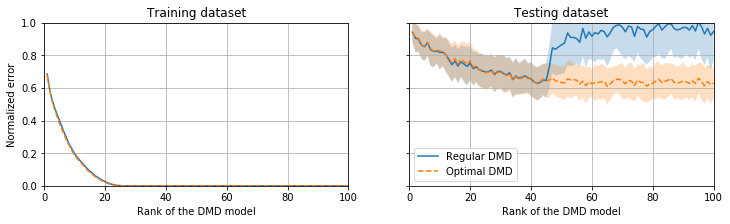

In [13]:
# --> Plot the results.
plot_rank_sensitivity(*output)

## Case 3 : Fitting a DMD model using an ensemble of trajectories

In [14]:
def generate_ensemble_time_series(dsys, n_traj, len_traj):
    
    """
    Utility function to generate a training dataset formed by an ensemble of time-series.
    
    Parameters
    -----------
    
    dsys : scipy.signal.dlti
        The discrete LTI system considered.
        
    n_traj : int
        The numbr of trajectories forming our ensemble.
        
    len_traj : int
        The length of each time-series.
        
    Returns
    -------
    
    X : array-like, shape (n_features, n_samples)
        The input to the system.
        
    Y : array-like, shape (n_features, n_samples)
        The output of the system.
    
    """
    
    for i in range(n_traj):
        # --> Training initial condition.
        x0_train = normal(loc=0.0,scale=1.0,size=(dsys.A.shape[1]))

        # --> Run simulation to generate dataset.
        t, _, x = dlsim(dsys, np.zeros((len_traj, dsys.inputs)), x0=x0_train)

        # --> Store the data.
        if i == 0:
            X, Y = x.T[:, :-1], x.T[:, 1:]
        else:
            X, Y = np.c_[X, x.T[:, :-1]], np.c_[Y, x.T[:, 1:]]
    return X, Y

In [15]:
def rank_sensitvity_bis(dsys, X, Y, n_test=100):
    
    """
    Same as before but for the ensemble training. Note that no DMD model is fitted, only OptDMD.
    """
    
    optdmd_train_error, optdmd_test_error = list(), list()
    
    # --> Fit a DMD model for each possible rank.
    for rank in range(1, dsys.A.shape[0]+1):
        
        # --> Fit the DMD model (optimal closed-form solution)
        optdmd = OptDMD(svd_rank=rank, factorization="svd").fit(X, Y)

        # --> One-step ahead prediction using both DMD models.
        y_predict_opt = optdmd.predict(X)

        # --> Compute the one-step ahead prediction error.
        optdmd_train_error.append( norm(y_predict_opt-Y)/norm(Y) ) 
        
        # --> Evaluate the error on test data.
        optdmd_error = list()
        for _ in range(n_test):
            # --> Test initial condition.
            x0_test = normal(loc=0.0,scale=1.0,size=(dsys.A.shape[1]))

            # --> Run simulation to generate dataset.
            t, _, x_test = dlsim(dsys, np.zeros((250, dsys.inputs)), x0=x0_test)
            
            # --> Split the training data into input/output snapshots.
            y_test, X_test = x_test.T[:, 1:], x_test.T[:, :-1]

            # --> One-step ahead prediction using both DMD models.
            y_predict_opt = optdmd.predict(X_test)

            # --> Compute the one-step ahead prediction error.
            optdmd_error.append( norm(y_predict_opt-y_test)/norm(y_test) ) 

        # --> Store the error for rank i DMD.
        optdmd_test_error.append( np.asarray(optdmd_error) )

    # --> Complete rank-sensitivity.
    optdmd_test_error = np.asarray(optdmd_test_error)
    optdmd_train_error = np.asarray(optdmd_train_error)
    
    return optdmd_train_error, optdmd_test_error

In [16]:
def plot_rank_sensitivity_bis(
    short_time_series_optdmd_train, short_time_series_optdmd_test,
    long_time_series_optdmd_train, long_time_series_optdmd_test,
    optdmd_train_error, optdmd_test_error
):

    """
    Same as before for this second rank sensitivity analysis.
    """
    
    # --> Generate figure.
    fig, axes = plt.subplots( 1, 2,  figsize=(fig_width, fig_width/4), sharey=True, sharex=True )
    
    # --> Misc.
    rank = np.arange(1, optdmd_train_error.shape[0]+1)

    #####
    #####     TRAINING ERROR
    #####
    
    # --> Training error using a short time-series to fit the model.
    axes[0].plot( rank, short_time_series_optdmd_train )
    # --> Training error using a long time-series to fit the model.
    axes[0].plot( rank, long_time_series_optdmd_train )
    # --> Training error using an ensemble of short time-series to fit the model.
    axes[0].plot( rank, optdmd_train_error )

    # --> Add decorators.
    axes[0].set(
        xlim=(0, rank.max()), ylim=(0, 1),
        xlabel=r"Rank of the DMD model", ylabel=r"Normalized error",
        title=r"Training dataset"
    )
    axes[0].grid(True)

    #####
    #####     TESTING ERROR
    #####
    
    # --> Testing error for the model fitted with a short time-series.
    axes[1].plot( rank, np.mean(short_time_series_optdmd_test, axis=1), label=r"Short time-series" )
    axes[1].fill_between(
        rank,
        np.mean(short_time_series_optdmd_test, axis=1) + np.std(short_time_series_optdmd_test, axis=1),
        np.mean(short_time_series_optdmd_test, axis=1) - np.std(short_time_series_optdmd_test, axis=1),
        alpha=0.25,
    )

    # --> Testing error for the model fitted with a long time-series.
    axes[1].plot( rank, np.mean(long_time_series_optdmd_test, axis=1), label=r"Long time-series" )
    axes[1].fill_between(
        rank,
        np.mean(long_time_series_optdmd_test, axis=1) + np.std(long_time_series_optdmd_test, axis=1),
        np.mean(long_time_series_optdmd_test, axis=1) - np.std(long_time_series_optdmd_test, axis=1),
        alpha=0.25,
    )
    
    # --> Testing error for the model fitted using an ensemble of trajectories.
    axes[1].plot( rank, np.mean(optdmd_test_error, axis=1), label=r"Ensemble" )
    axes[1].fill_between(
        rank,
        np.mean(optdmd_test_error, axis=1) + np.std(optdmd_test_error, axis=1),
        np.mean(optdmd_test_error, axis=1) - np.std(optdmd_test_error, axis=1),
        alpha=0.25,
    )

    # --> Add decorators.
    axes[1].set(
        xlim=(0, rank.max()), ylim=(0, 1),
        xlabel=r"Rank of the DMD model", title=r"Testing dataset"
    )
    axes[1].grid(True)
    axes[1].legend(loc=0)

    return

### Case 3.1 : Small ensemble

In [17]:
# --> Number of trajectories and length.
n_traj, len_traj = 10, 10
X, Y = generate_ensemble_time_series(dsys, n_traj, len_traj)

# --> Run the rank-sensitivity analysis.
optdmd_train_error, optdmd_test_error = rank_sensitvity_bis(dsys, X, Y)

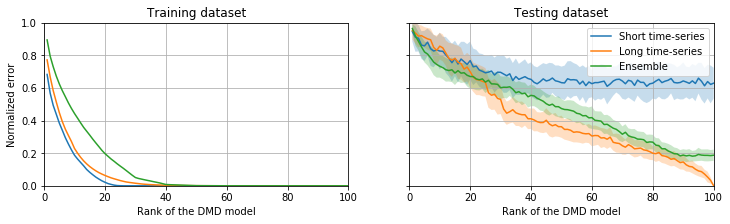

In [18]:
plot_rank_sensitivity_bis(
    short_time_series_optdmd_train, short_time_series_optdmd_test,
    long_time_series_optdmd_train, long_time_series_optdmd_test,
    optdmd_train_error, optdmd_test_error
)

### Case 3.2 : Large ensemble

In [19]:
# --> Number of trajectories and length.
n_traj, len_traj = 200, 10
X, Y = generate_ensemble_time_series(dsys, n_traj, len_traj)

# --> Run the rank-sensitivity analysis.
optdmd_train_error, optdmd_test_error = rank_sensitvity_bis(dsys, X, Y)

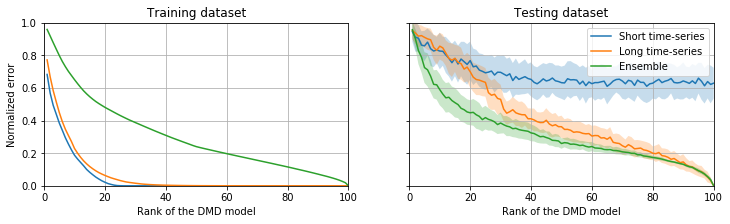

In [20]:
plot_rank_sensitivity_bis(
    short_time_series_optdmd_train, short_time_series_optdmd_test,
    long_time_series_optdmd_train, long_time_series_optdmd_test,
    optdmd_train_error, optdmd_test_error
)

## Conclusion

These various tests show that:
- The models fitted using the new `OptDMD` consistently have smaller errors both on the training and testing datasets as compared to the regular `DMD`, no matter whether one has few data or a lot of data.
- When a single time-series is used, both `DMD` and `OptDMD` models tend to actually overfit the training data. Indeed, a zero reconstruction error can be achieved for a low-rank model on the training data. The same models however poorly generalize to new testing data.
- In order to prevent this overfitting problem, using an ensemble of bursts (i.e. short time-series) to fit the model appear to be extremely beneficial. In this case, the model's error on the testing dataset is of the same order as the error on the training one. Using such an ensemble of trajectories is moreover data-efficient : for a given reconstruction error, `OptDMD` models fitted using an ensemble of trajectories require actually less data than models fitted using a single time-series.